In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
import importlib

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

In [2]:
# plotting settings
plt.rcParams['font.size'] = 14

In [143]:
# constants
csts = dict()
csts['k'] = 1.380649e-23  # J/K
csts['A'] = 3.15*0.92*1e-6  # m
csts['L'] = 10.00e-3  # m
csts['I'] = 10.0e-3  # A
csts['I_err'] = 0.001*1e-3  # A
csts['t'] = 0.93e-3  # m
csts['q'] = 1.6e-19  # C

## Interpolate Data

#### Functions

In [4]:
def v_to_mag(v_to_convert):
    """
    Get field strength from a voltage reading
    """
    calib_raw = pd.read_excel('magnet_calibration.xlsx')
    voltage = calib_raw['Hall Probe Reading'].values[2:]
    field = calib_raw['Magnetic Flux Reading'].values[2:]

    func = interp1d(voltage, field, bounds_error=False, fill_value="extrapolate")
    field_interp = func(v_to_convert)
    return field_interp

In [5]:
def interp_data(dataset, T_common):
    """
    Interpolate first over time (to match data within the file) 
    and then over temperature (to match data between files)
    """
    interp_dataset = dict()

    # Interpolating over time
    common_time = dataset["t9"]  # using time of temperature readings
    # Go through channels
    for i in range(1, 8):
        interp_data = interp1d(dataset[f't{i}'], dataset[f'v{i}'], bounds_error=False, fill_value="extrapolate")  # interpolate data for channel i
        interp_dataset[f'v{i}'] = interp_data(common_time)  # interpolate data for channel i at common time

    # Interpolating over temperature
    for i in range(1, 8):
        interp_data = interp1d(dataset['T'], interp_dataset[f'v{i}'], bounds_error=False, fill_value="extrapolate")  # interpolate data for channel i
        interp_dataset[f'v{i}'] = interp_data(T_common)  # updating data for channel i at common Temperature
    
    # Save temperature arrays
    interp_dataset['T_original'] = dataset['T']
    interp_dataset['T_common'] = T_common
    
    return interp_dataset

#### Interpolate

In [6]:
# defining the common temperature array we want to interpolate over
T_common = np.linspace(-100, 80, 1000) # Celcius

In [7]:
# read the files listed in the .txt and interpolate them
mag_field_dict = dict()
file_list = user_path + '/PHYS469/hall_experiment/good_data_list.txt'  # files need to be in order of increasing field strength
raw_data = dict()

with open(file_list, 'r') as f:
    for line in f:
        # Read in data file
        line = line.strip()
        dataset = pd.read_csv(user_path + line, header=2)

        # Get field strength from file name
        field_voltage = float(line.split('/')[-1].split('.')[0][:-2])
        field_strength = v_to_mag(field_voltage)
        
        # Keep raw data in a dict
        raw_data[str(field_strength)] = dataset

        # Interpolate the data
        run_dict = interp_data(dataset, T_common)
        # Save data in dict with field strength as key
        mag_field_dict[str(field_strength)] = run_dict

# print(f'{mag_field_dict.keys()}\n{mag_field_dict['275.7'].keys()}')

In [8]:
# Combining the voltage data at diff fields into single arrays, in a single dict
voltage_dict = dict()

# Adding temperature array
voltage_dict['T_common'] = T_common
# Adding field strength array
voltage_dict['B_array'] = np.array([float(field) for field in mag_field_dict.keys()])
# Adding voltage matrices
for i in range(1, 8):
    voltage_dict[f'v{i}'] = np.array([mag_field_dict[field][f'v{i}'] 
                                      for field in mag_field_dict.keys()]).T  # shape (N_B, N_T)
    
print(voltage_dict.keys())

dict_keys(['T_common', 'B_array', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7'])


## Functions

In [9]:
def get_temp(T, dict=voltage_dict):
    """
    Return index and value of closest temperature to T in the temperature array of dict
    """
    # Find data at the temperature
    T_index = np.argmin(np.abs(dict['T_common'] - T))
    T = dict['T_common'][T_index]

    return T, T_index

In [10]:
def get_field(B, dict=voltage_dict):
    """
    Return index and value of closest field to B in the field array of dict
    """
    B_index = np.argmin(np.abs(dict['B_array'] - B))
    B = dict['B_array'][B_index]

    return B, B_index

## 3d Interpolated Data Plots

Yes, the two functions below do the exact same thing :)

In [11]:
# def voltage_3d_plot_from_field_dict(channel, mag_field_dict=mag_field_dict):
#     """
#     Make the 3d plot from a magnetic field dict
#     keys are fields, with values being other dictionaries that store the voltages
#     """
    
#     # Channel info
#     channel_num = channel[1]

#     # Data
#     V = np.array([mag_field_dict[B][channel] for B in mag_field_dict.keys()])  # shape (n_B, n_T)
#     V = V.T  # shape (n_T, n_B)
#     B = [float(field) for field in mag_field_dict.keys()]  # Field values in mT

#     # Plot
#     plt.figure(figsize=(6,4), dpi=150)
#     extent = (mag_field_dict['T_common'][0], mag_field_dict['T_common'][-1], B[-1], B[0])
#     plt.imshow(np.abs(V), aspect='auto', cmap='viridis', extent=extent)
#     plt.title(f"Channel {channel_num} Voltage")
#     plt.colorbar(label='Voltage [V]')
#     plt.xlabel("Temperature [C]")
#     plt.ylabel("Magnetic Field [mT]")
#     plt.show()

In [183]:
def voltage_3d_plot_from_volt_dict(channel, data_dict=voltage_dict):
    """
    Make the 3d plot from a voltage data dictionary
    voltage arrays are in the form of a matrix with shape (n_T, n_B), ie, already concatenated along the B axis
    """
    # Channel info
    channel_num = channel[1]

    # Data
    V = data_dict[channel].T  # shape (n_B,n_T)
    B = data_dict['B_array'] # Field values in mT
    T = data_dict['T_common']  # Temperature values in C

    # Plot
    plt.figure(figsize=(6,4), dpi=250)
    extent = (T[0], T[-1], B[-1], B[0])
    plt.imshow(np.abs(V), aspect='auto', cmap='viridis', extent=extent)#, interpolation='none')
    plt.title(f"Channel {channel_num} Voltage")
    plt.colorbar(label='Voltage [V]')
    plt.xlabel("Temperature [C]")
    plt.ylabel("Magnetic Field [mT]")
    plt.tight_layout()
    plt.savefig(f'figures/{channel}_3d_voltage.png', bbox_inches='tight')
    plt.show()

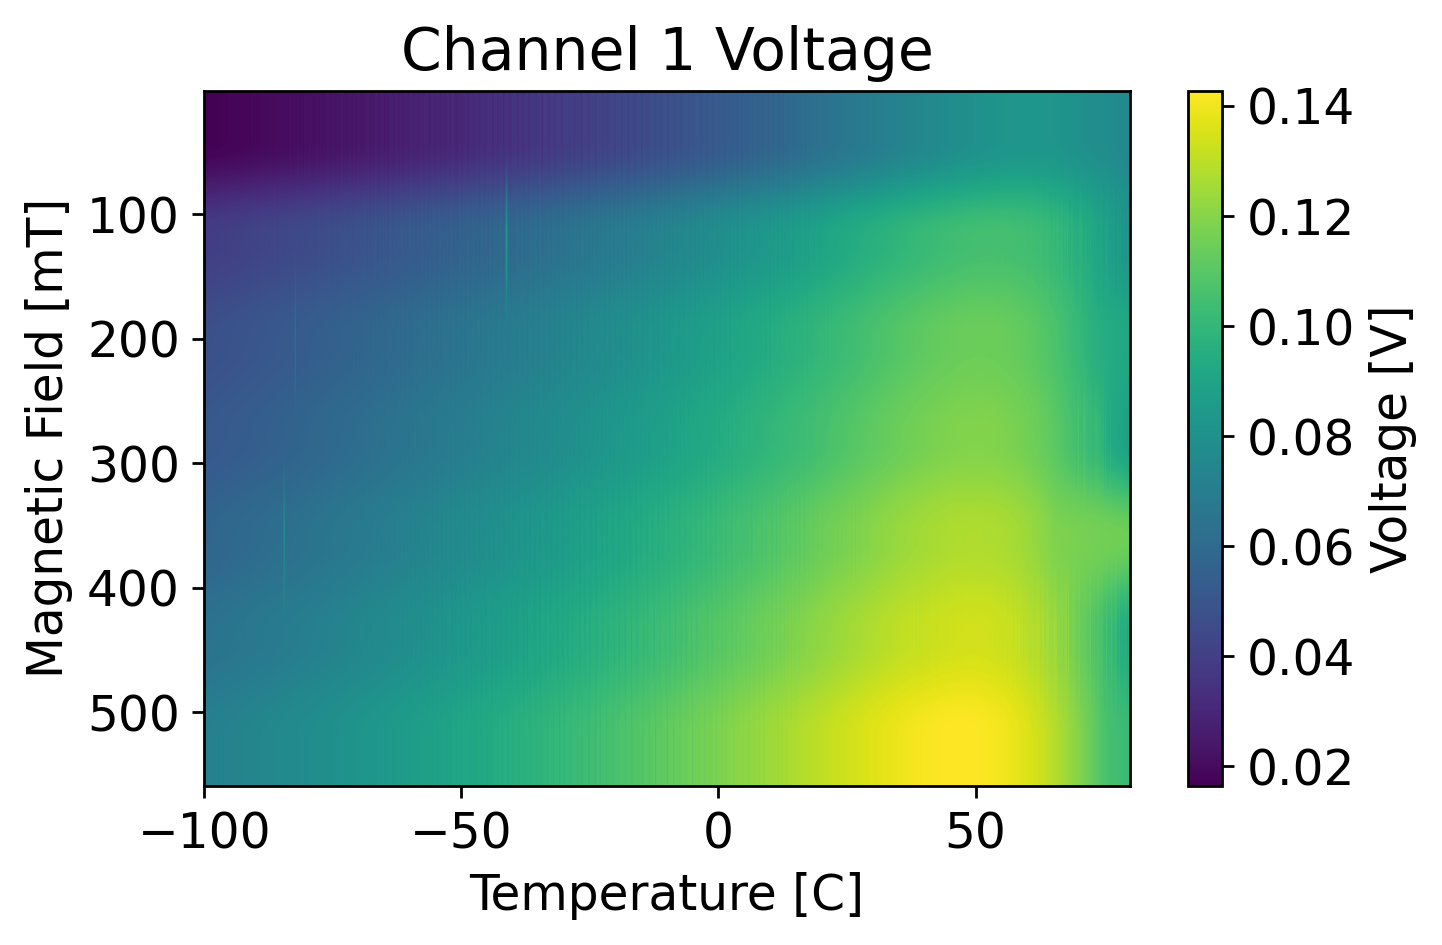

In [184]:
for channel in ['v1']:#, 'v2', 'v3', 'v4', 'v5', 'v6', 'v7']:
    voltage_3d_plot_from_volt_dict(channel)

## Resistivity

In [14]:
def resistivity(V, csts):
    """
    Calculate resistivity from voltage at a fixed B
    """
    return V * csts['A'] / (csts['I'] * csts['L'])

In [15]:
def resistivity_array(dict=voltage_dict, csts=csts):
    """
    Calculate resistivity for all B and T
    """
    # Get voltage data at ambient field for V5 & V7
    V5 = dict['v5']
    V7 = dict['v7']
    # Calcylate Vx
    Vx = (V5+V7)/2
    
    # Calculate resistivity
    rho = resistivity(Vx, csts)  # shape (N_T, N_B)

    return rho

In [181]:
def plot_resistivity(B, dict=voltage_dict, csts=csts):
    # Get ambient field
    B_ambient, B_ambient_index = get_field(B)
    # Get temperature
    T = dict['T_common']
    
    rho = resistivity_array(dict, csts)[:,B_ambient_index]

    # Plot
    plt.figure(figsize=(9,4), dpi=200)
    plt.scatter(T, rho, marker='o',s=4, label = 'Interpolated data')
    # plt.title(f"Resistivity at {B_ambient:.1f} mT, Interpolated Data")
    plt.xlabel("Temperature [C]")
    plt.ylabel(r"Resistivity [$\Omega$m]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/{B_ambient:.1f}mT_resistivity.png', bbox_inches='tight')
    plt.show()
    
    return rho

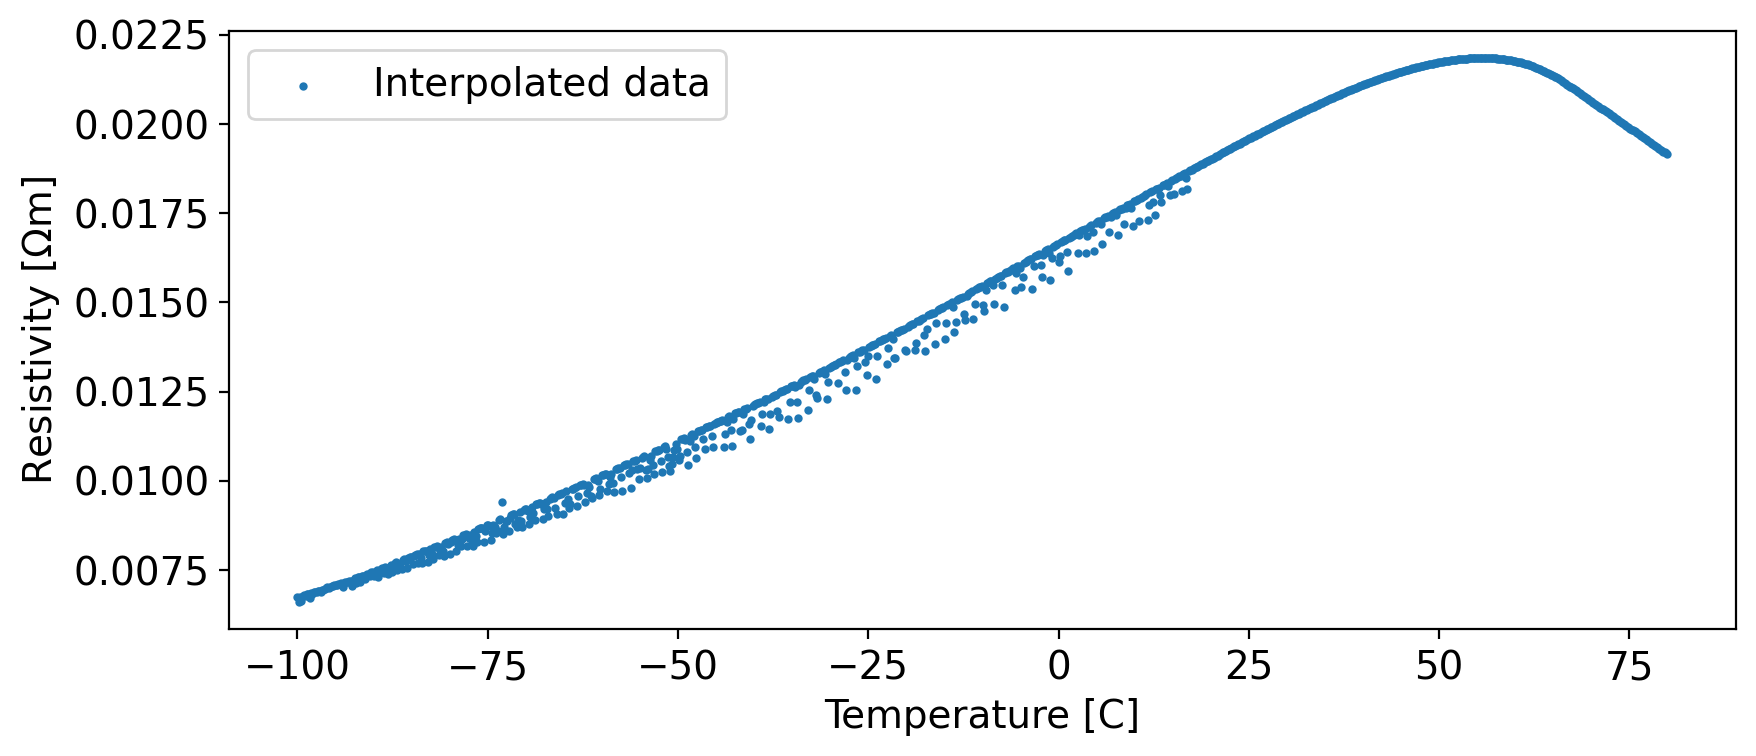

In [182]:
B_ambient = 0  # mT
rho_ambient_field = plot_resistivity(B_ambient)

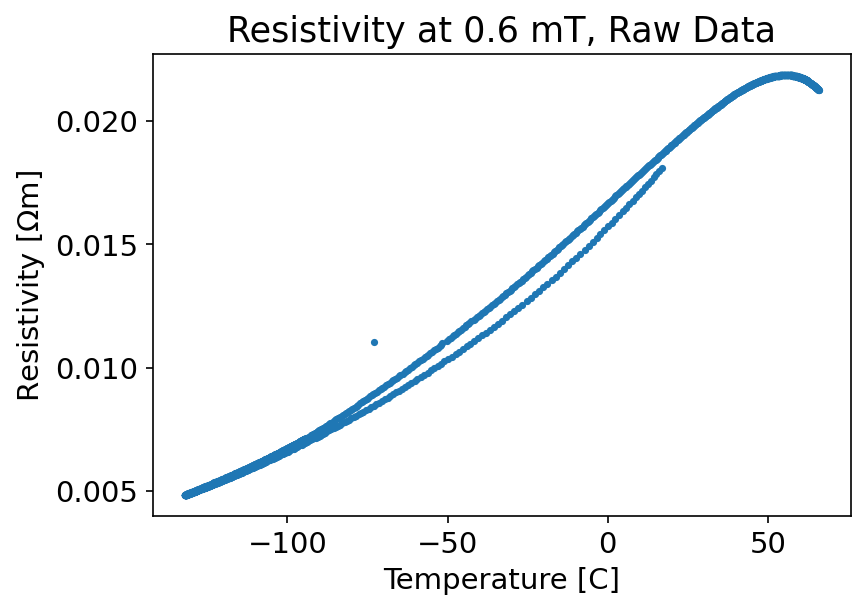

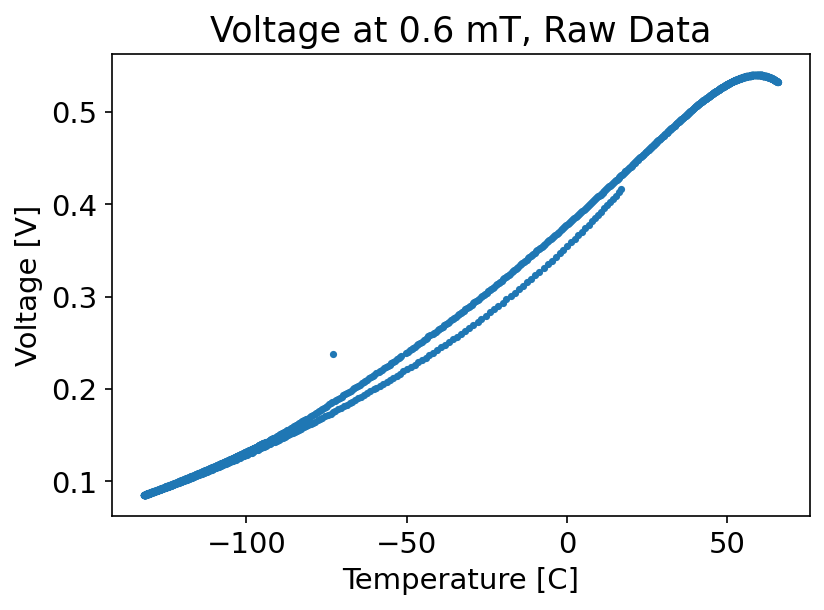

In [18]:
# Using this code cell to check if the weird line is due to 
# interpolation or if it's in the raw data...

B = float(list(raw_data.keys())[0])
T = raw_data[f'{B}']['T']

# Get voltage data at ambient field for V5 & V7
V5 = raw_data[f'{B}']['v5']
V7 = raw_data[f'{B}']['v7']
# Calcylate Vx
Vx = (V5+V7)/2

# Calculate resistivity
rho = resistivity(Vx, csts)

# Plot
plt.figure(figsize=(6,4), dpi=150)
plt.scatter(T, rho, marker='o',s=6)
plt.title(f"Resistivity at {B:.1f} mT, Raw Data")
plt.xlabel("Temperature [C]")
plt.ylabel(r"Resistivity [$\Omega$m]")
plt.show()

plt.figure(figsize=(6,4), dpi=150)
plt.scatter(T, V5, marker='o',s=6)
plt.title(f"Voltage at {B:.1f} mT, Raw Data")
plt.xlabel("Temperature [C]")
plt.ylabel("Voltage [V]")
plt.show()


## Carrier Concentration

In [177]:
def plot_hall_voltage(T, dict=voltage_dict, csts=csts):
    """
    Plot hall voltage as a function of magnetic field for fixed temperatures
    """
    # Get temperature
    T, T_index = get_temp(T)
    # Get voltage data at temperature for V5 & V7
    V1 = dict['v1'][T_index]
    V2 = dict['v2'][T_index]

    # Calculate VH
    VH = (V1+V2)/2

    # get errors on VH
    error_V1 = 1e-3
    error_V2 = 1e-3
    error_VH = np.sqrt((error_V1)**2 + (error_V2)**2)


    # Fit to VH = BI/qt * 1/n get n from slope
    def fit_func(B, n, b):
        return -B * csts['I'] / (csts['q'] * csts['t'] * n) + b

    popt, pcov = opt.curve_fit(fit_func, dict['B_array'], VH, p0 = [0.5, -0.05])
    n = popt[0]
    b = popt[1]
    n_err = np.sqrt(pcov[0,0])
    b_err = np.sqrt(pcov[1,1])
    print(f"n = {n:.2e} ± {n_err:.2e} m^3")
    print(f"b = {b:.2f} ± {b_err:.2e} V")


    # Plot
    fig = plt.figure(figsize=(6, 6), dpi=200)
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)

    # Data and fit
    ax_main = fig.add_subplot(gs[0])
    ax_main.errorbar(dict['B_array'], VH, yerr=error_VH, fmt='o', markersize=3, label = 'Interpolated data', capsize = 3)
    ax_main.plot(dict['B_array'], fit_func(dict['B_array'], n, b), label=f'Fit n = {n:.2e} m'+r'$^{-3}$', color = 'black')
    ax_main.set_ylabel("Hall Voltage [V]")
    ax_main.set_title(rf"Hall Voltage at {T:.1f}$\degree$C")
    ax_main.legend()

    # Residuals in terms of percentage
    ax_res = fig.add_subplot(gs[1])
    residuals = (VH - fit_func(dict['B_array'], n, b)) / VH * 100

    ax_res.errorbar(dict['B_array'], residuals, yerr=error_VH, fmt='o', markersize=3, capsize = 3)
    ax_res.axhline(0, color='black', linestyle='--')
    ax_res.set_xlabel("Magnetic Field [mT]")
    ax_res.set_ylabel("Residuals [%]")

    plt.setp(ax_main.get_xticklabels(), visible=False)
    plt.tight_layout()
    plt.savefig(f'figures/carrier-concen-{T:.0f}C.png', bbox_inches='tight')
    plt.show()

n = 7.15e+23 ± 2.90e+22 m^3
b = -0.02 ± 1.39e-03 V


/var/folders/8r/nd1rwfxs3vd_hvxw9nj4rqp00000gn/T/ipykernel_6138/2996969576.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


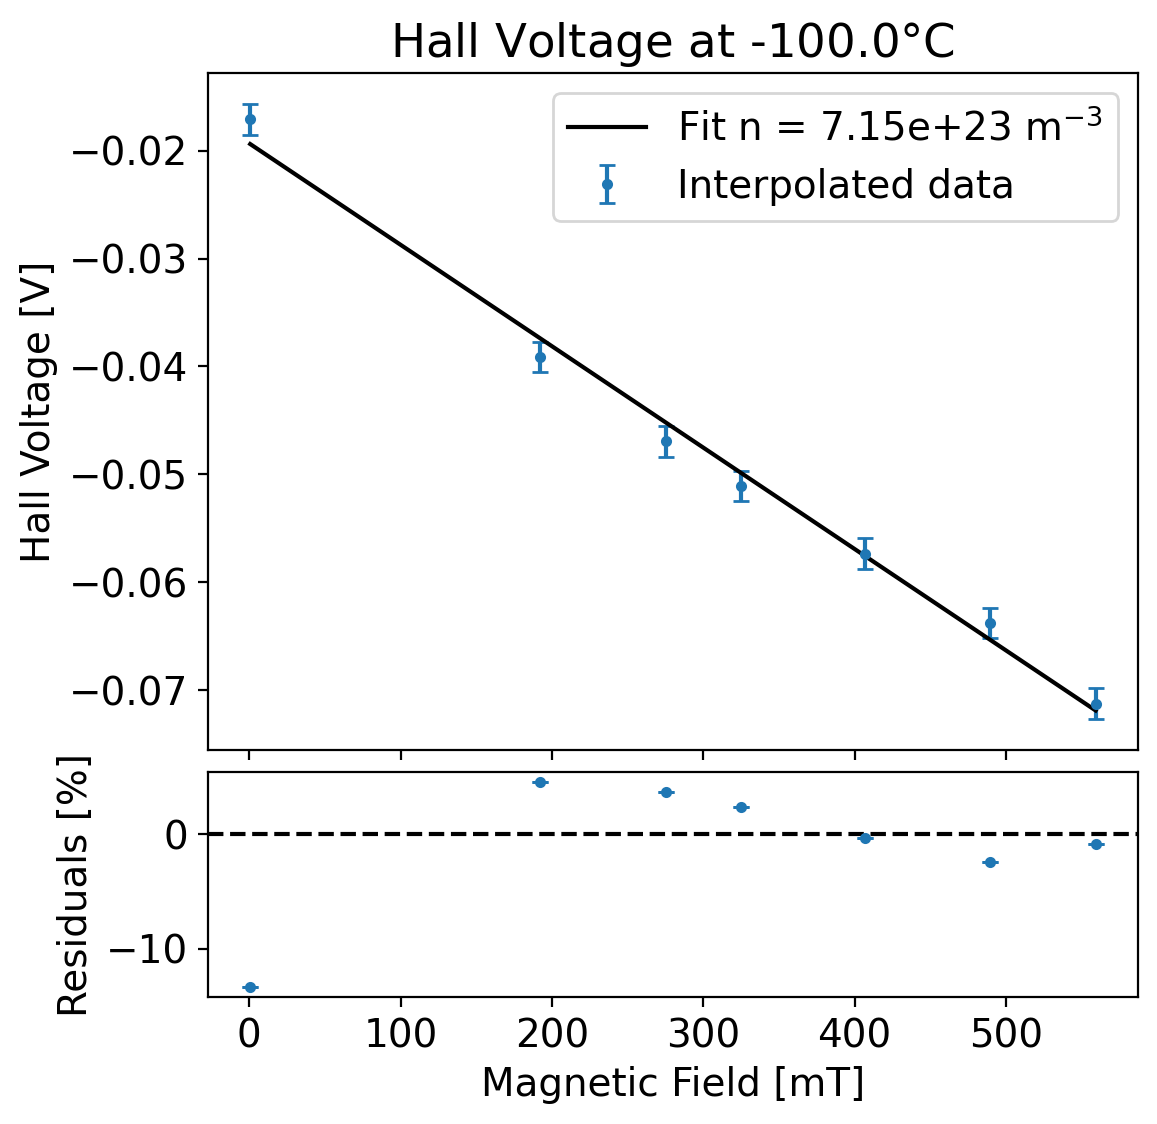

n = 6.72e+23 ± 3.14e+22 m^3
b = -0.03 ± 1.71e-03 V


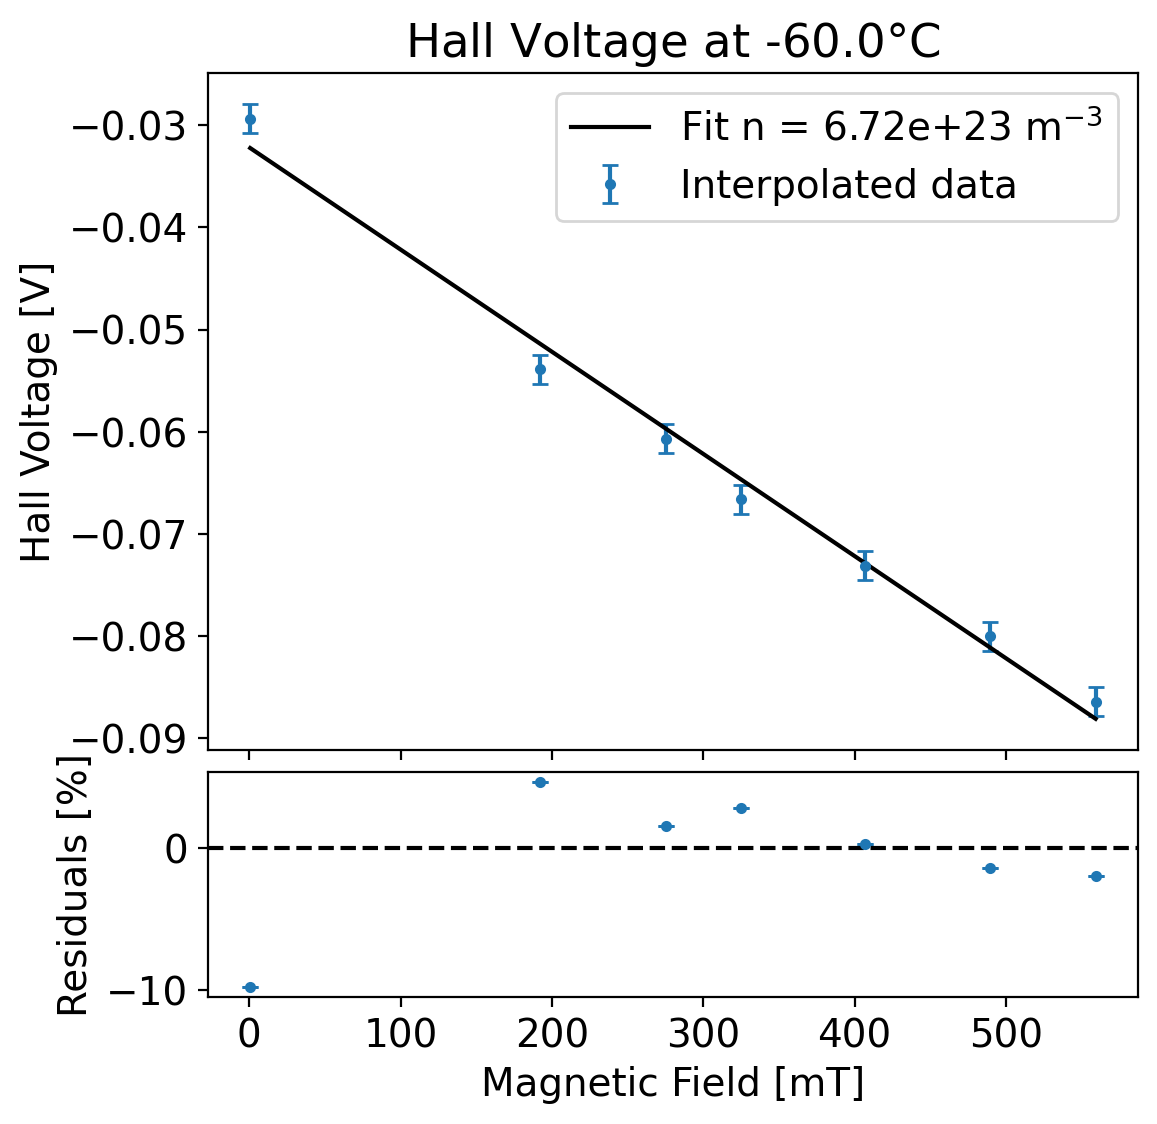

n = 5.79e+23 ± 2.76e+22 m^3
b = -0.06 ± 2.03e-03 V


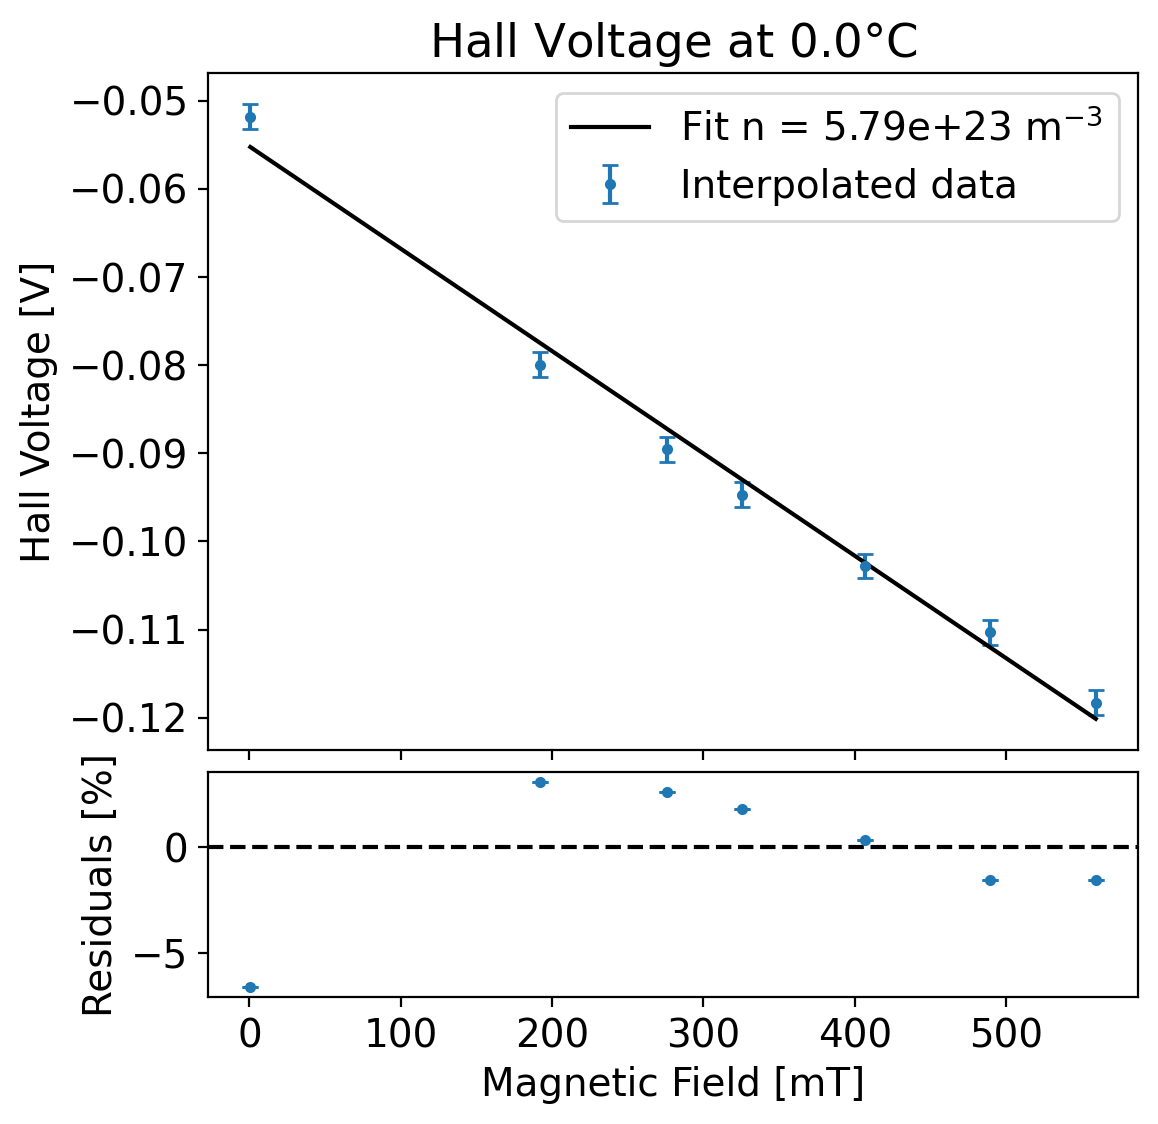

n = 7.13e+23 ± 1.96e+22 m^3
b = -0.08 ± 9.51e-04 V


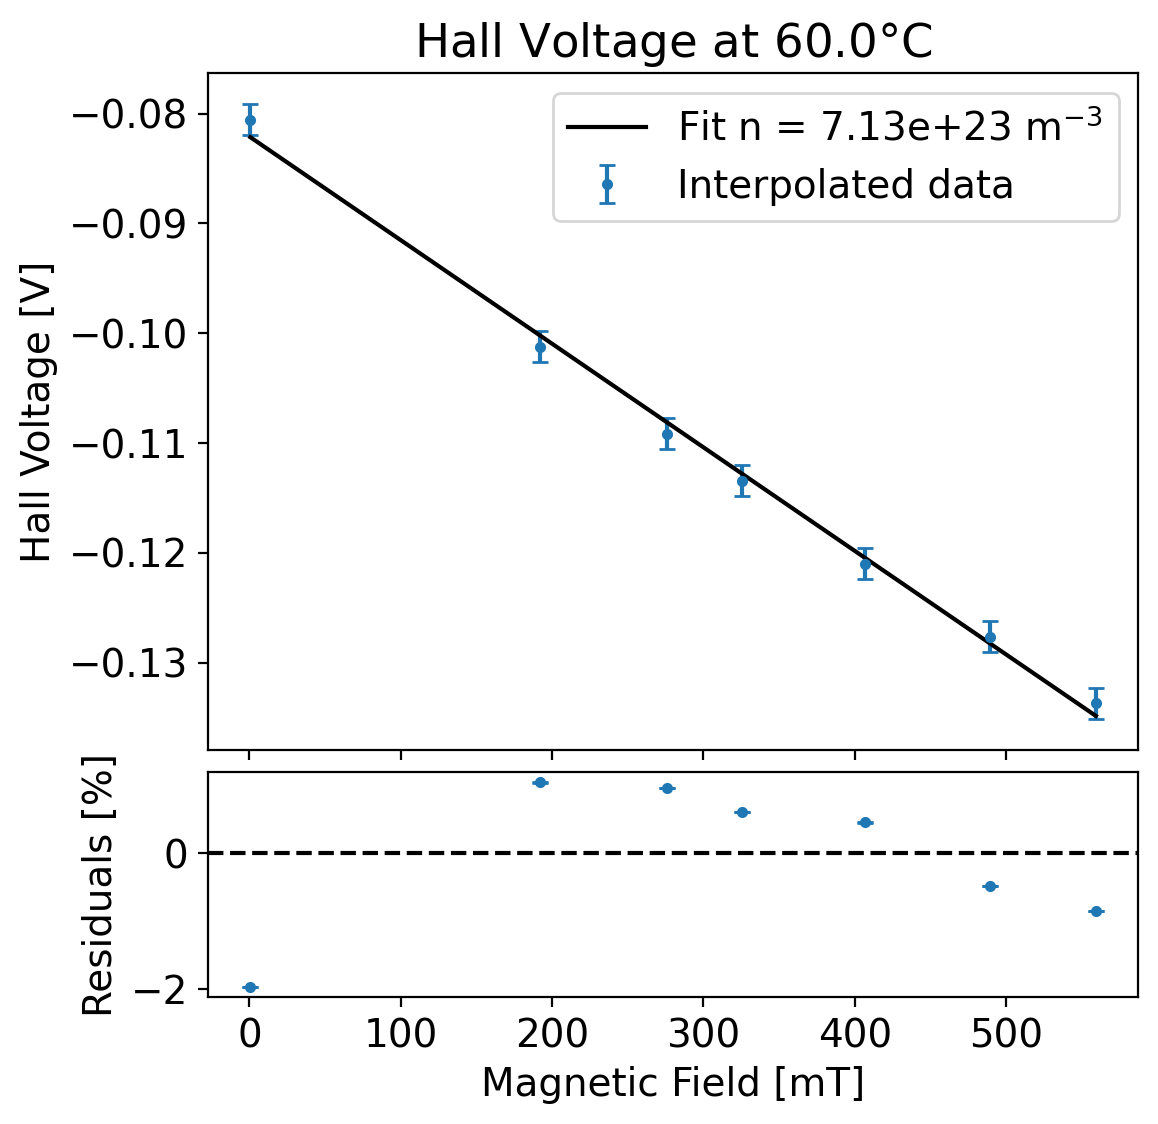

n = 1.37e+24 ± 5.73e+23 m^3
b = -0.07 ± 7.55e-03 V


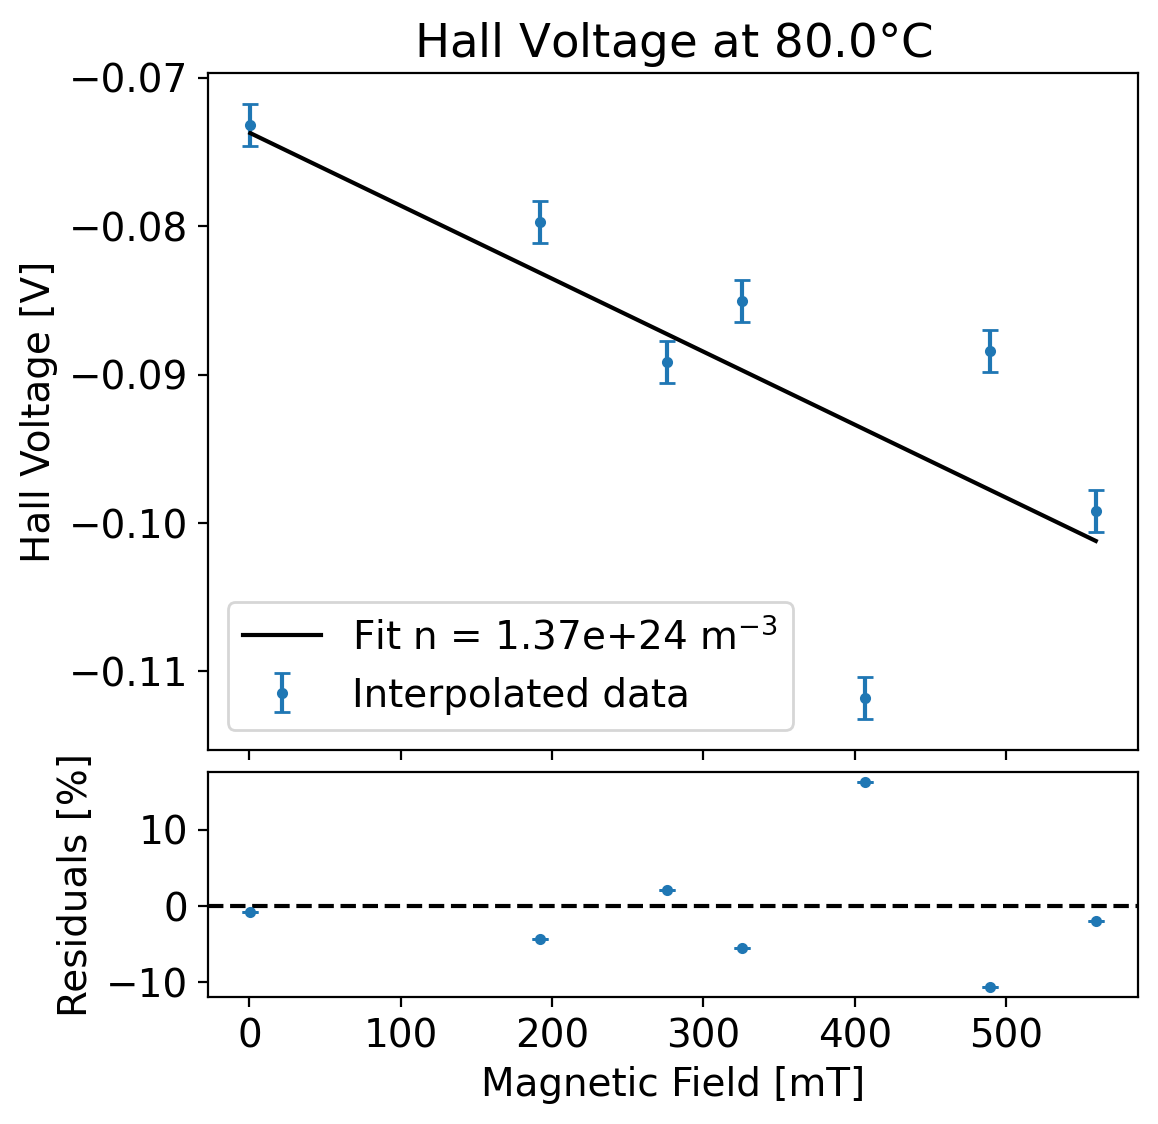

In [178]:
T_min = T_common[0]
T_max = T_common[-1]

plot_hall_voltage(T_min)
plot_hall_voltage(-60)
plot_hall_voltage(0)
plot_hall_voltage(60)
plot_hall_voltage(T_max)

### Carrier concentration vs temperature

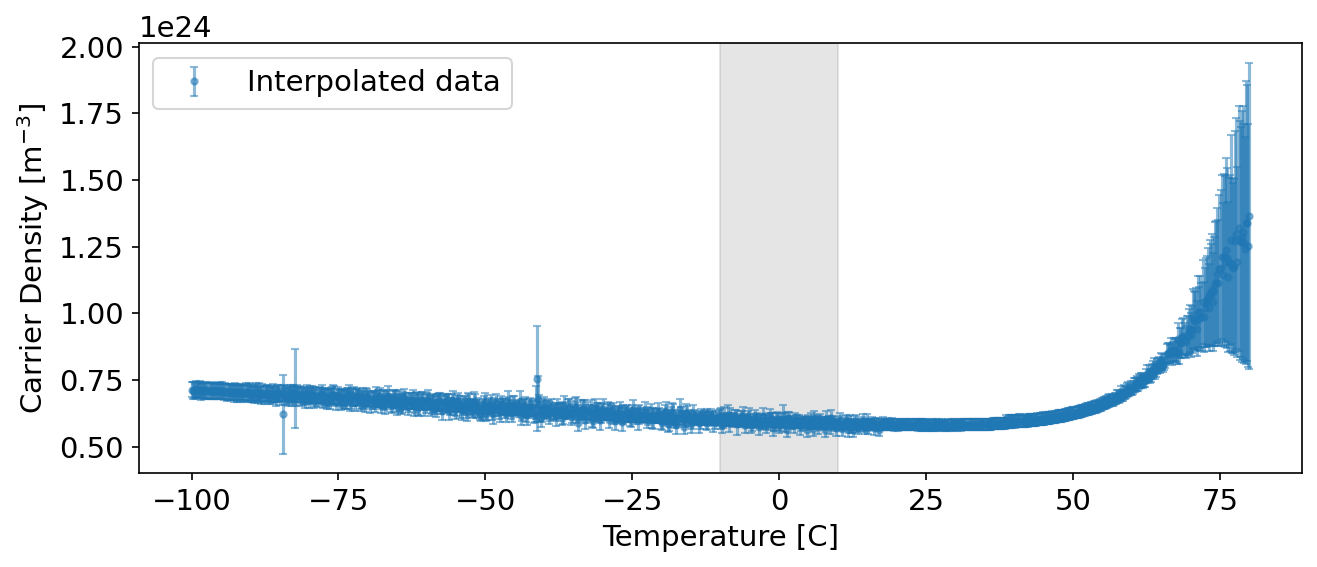

In [198]:
n_dict = dict()
n_err_dict = dict()

for T in T_common:
    # Get temperature
    T, T_index = get_temp(T)
    # Get voltage data at temperature for V5 & V7
    V1 = voltage_dict['v1'][T_index]
    V2 = voltage_dict['v2'][T_index]

    # Calculate VH
    VH = (V1+V2)/2
    error_VH = np.sqrt((1e-3)**2 + (1e-3)**2)

    # fit to VH = BI/nqt * 1/n get n from slope
    def fit_func(B, n, b):
        return -B * csts['I'] / (csts['q'] * csts['t'] * n) + b

    popt, pcov = opt.curve_fit(fit_func, voltage_dict['B_array'], VH, p0 = [0.5, -0.05])
    n = popt[0]
    b = popt[1]
    # print(f"n = {n:.2e}m^3")
    # print(f'err on n: {np.sqrt(np.diag(pcov))[0]:.2e}')

    n_dict[T] = n
    n_err_dict[T] = np.sqrt(np.diag(pcov))[0]

# Plot
plt.figure(figsize=(9,4), dpi=150)
plt.errorbar(list(n_dict.keys()), list(n_dict.values()), yerr =list(n_err_dict.values()),  marker = '.', linestyle = 'None', capsize = 2, alpha = 0.5, label='Interpolated data')
plt.legend()
# plt.title("Carrier Density vs Temperature")

# gray out region from -10 to 10
plt.axvspan(-10, 10, color='gray', alpha=0.2)
plt.xlabel("Temperature [C]")
plt.ylabel("Carrier Density [m$^{-3}$]")
plt.tight_layout()
plt.savefig('figures/carrier-temp.png', bbox_inches='tight')
plt.show()

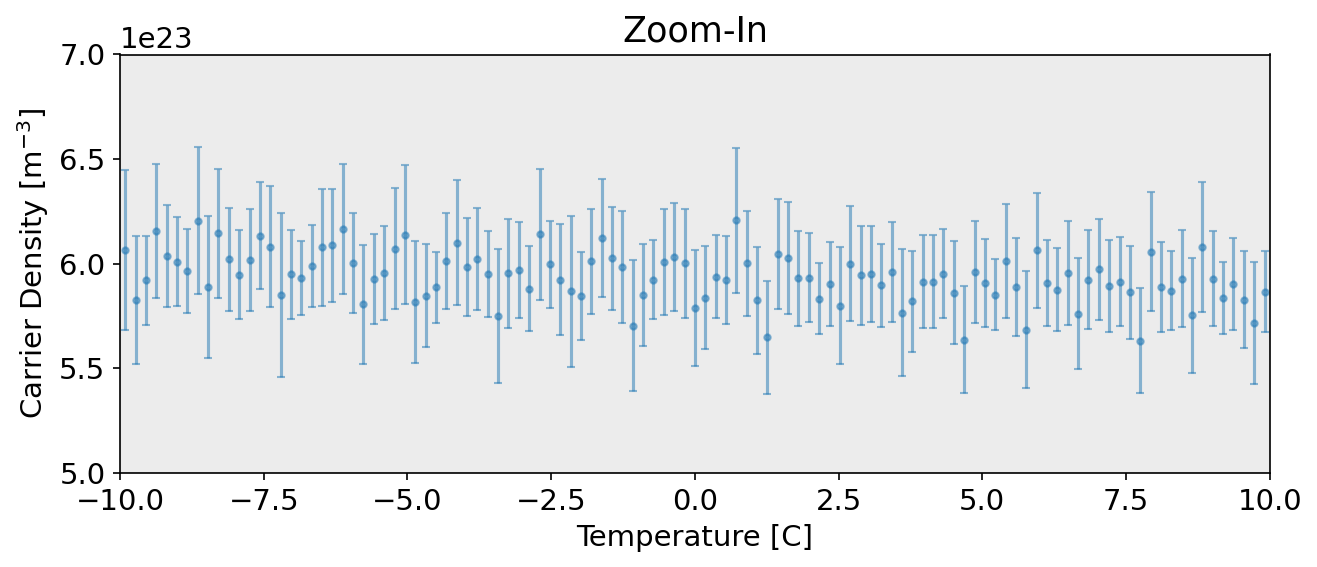

In [197]:
#zoom-in on the superconducting region
plt.figure(figsize=(9,4), dpi=150)
plt.axvspan(-10, 10, color='gray', alpha=0.15)
plt.errorbar(list(n_dict.keys()), list(n_dict.values()), yerr =list(n_err_dict.values()),  marker = '.', linestyle = 'None', capsize = 2, alpha = 0.5)
plt.xlim(-10, 10)
plt.ylim(0.5e24, 0.7e24)
plt.xlabel("Temperature [C]")
plt.ylabel("Carrier Density [m$^{-3}$]")
plt.title("Zoom-In")
plt.tight_layout()
plt.savefig('figures/carrier-temp-zoom.png', bbox_inches='tight')
plt.show()

In [23]:
# weighted average of n based on errors
n_avg = np.average(list(n_dict.values()), weights = [1/err**2 for err in n_err_dict.values()])
n_avg_err = np.sqrt(1/np.sum([1/err**2 for err in n_err_dict.values()]))

print(f"n_avg = {n_avg:.2e} +/- {n_avg_err:.2e} m^-3")

n_avg = 6.29e+23 +/- 8.32e+20 m^-3


## Carrier mobility / hall coefficient - MULTIPANEL <3

In [25]:
def mobility(n, rho, q=csts['q']):
    return 1/(n*q*rho)

In [169]:
def mobility_3d_plot(rho, n, T, B, q=csts['q']):
    """
    Make the 3d plot of mobility from resistivity 
    rho & n need to have shape (N_T, N_B)
    """
    mu = mobility(n,rho)  # shape (N_B, N_T)

    plt.figure(figsize=(10,5), dpi=200)
    extent = (T[0], T[-1], B[-1], B[0])
    plt.imshow(mu, aspect='auto', cmap='viridis', extent=extent)
    plt.colorbar(label=r'Mobility [$m^2$/Vs]')
    plt.xlabel("Temperature [C]")
    plt.ylabel("Magnetic Field [mT]")
    plt.tight_layout()
    plt.savefig('figures/mobility_3d.png')
    plt.show()

    return mu

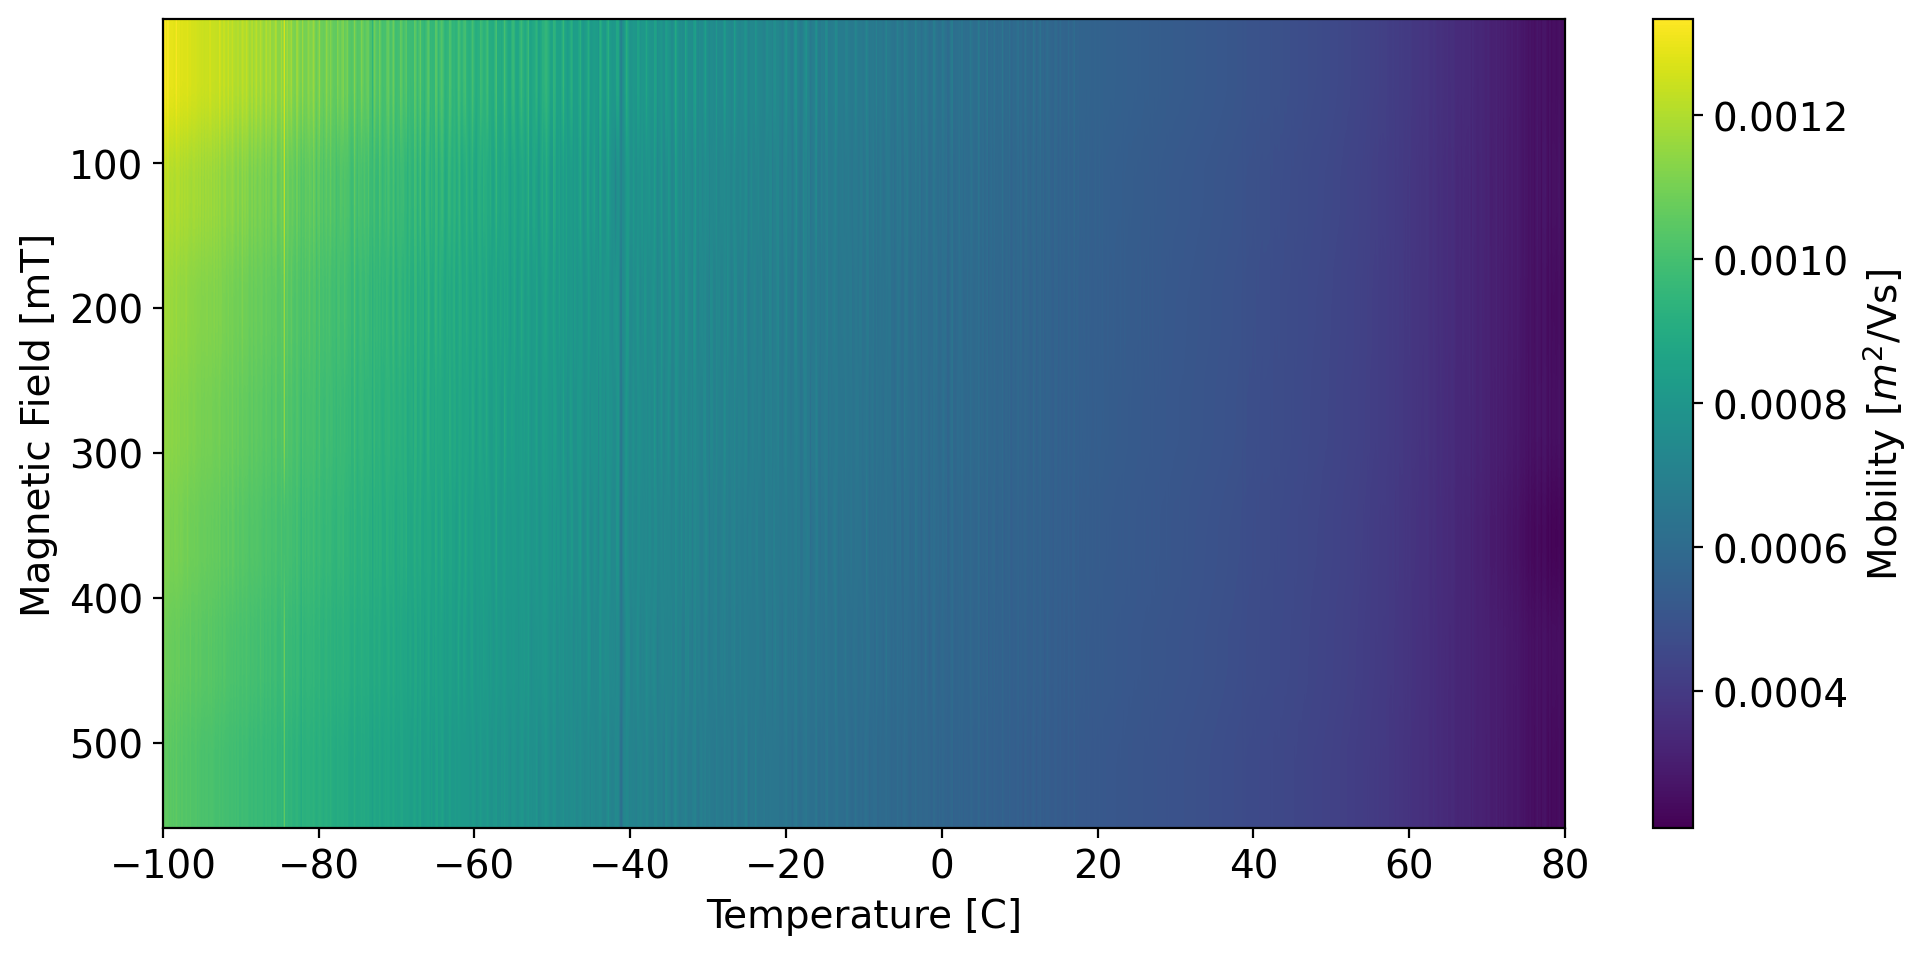

In [170]:
# Get data arrays
B = voltage_dict['B_array'] # shape (N_B), mT
T = voltage_dict['T_common']  # shape (N_T)
n_array = np.array([n_dict[temp] for temp in T_common]) # shape (N_T), m^-3
n_array = np.tile(n_array, (len(B), 1))  # shape (N_B, N_T), m^-3
rho = resistivity_array().T  # shape (N_B, N_T), Ohm*m

# Plot
mu = mobility_3d_plot(rho, n_array, T, B)

In [164]:
def mobility_slices_plot(mu, x_axis, mu_labels=[], T_axis=True):
    """
    Plot a slice of the 3d plot along the B or the T axis
    """
    axis_unit = 'C' if T_axis else 'mT'
    legend_unit = 'C' if not T_axis else 'mT'
    axis_name = 'Temperature' if T_axis else 'Magnetic Field'
    legend_label = 'T' if not T_axis else 'B'
    ms = 4 if T_axis else 20
    
    plt.figure(figsize=(8,5), dpi=150)
    for m,label in zip(mu,mu_labels):
        plt.scatter(x_axis, m, s=ms, label=f'{legend_label} = {label:.1f} {legend_unit}')
        if not T_axis:
            plt.plot(x_axis, m, lw=1)
    plt.xlabel(f"{axis_name} [{axis_unit}]")
    plt.ylabel(r'Mobility [$m^2$/Vs]')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/mobility_{legend_label}_slices.png')
    plt.show()

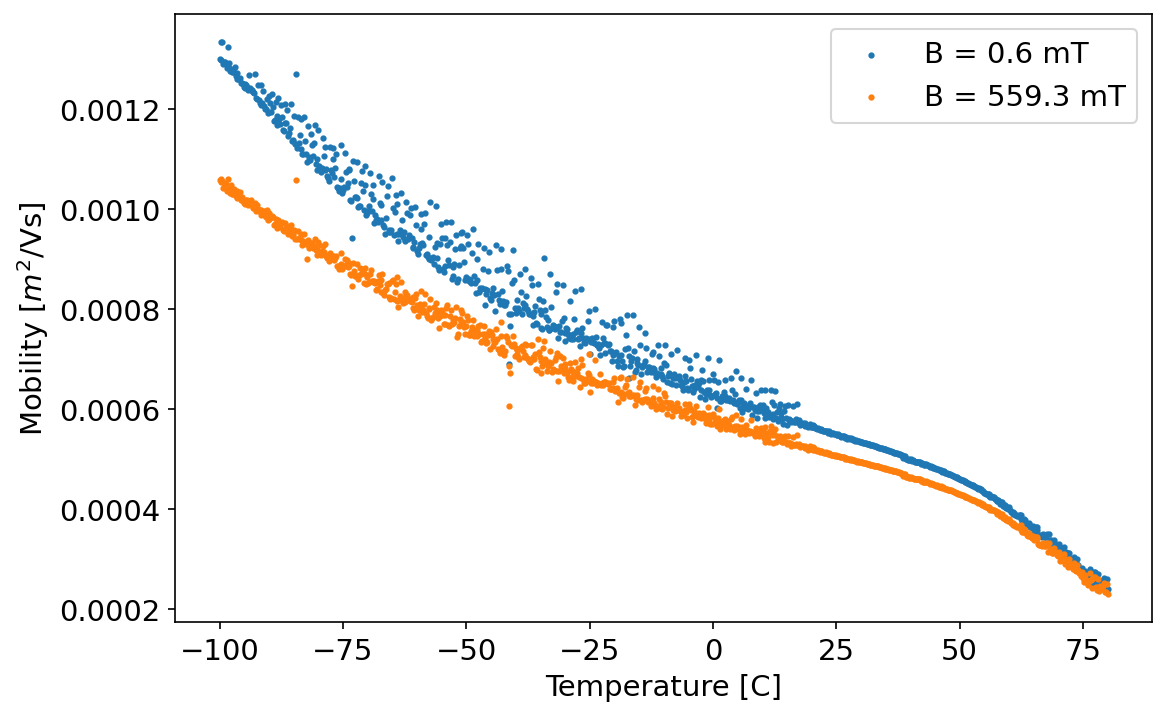

In [165]:
# Slice along B
mu_B_slices = mu[[0,-1]]   # mu for all T, at B indices 0 and -1
mu_B_labels = B[[0,-1]]
mobility_slices_plot(mu_B_slices, T, mu_labels=mu_B_labels, T_axis=True)

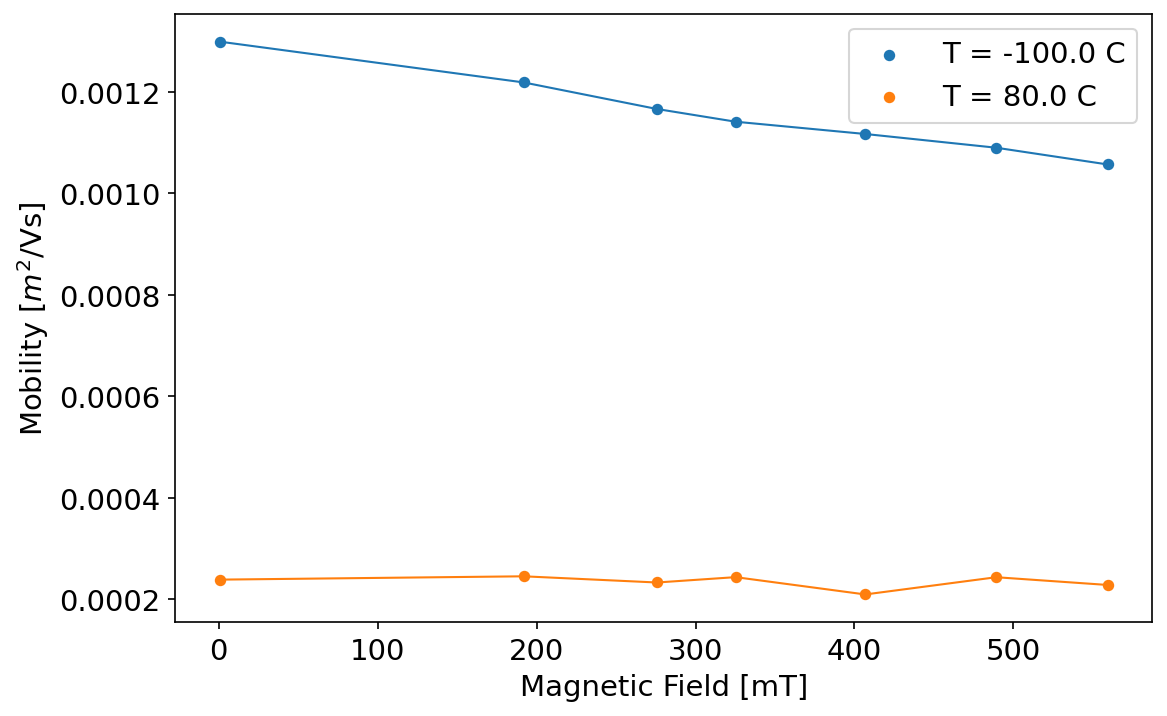

In [166]:
mu_T_slices = mu[:,[0,-1]].T  # mu for all B, at T indices 0 and -1
mu_T_labels = T[[0,-1]]
mobility_slices_plot(mu_T_slices, B, mu_labels=mu_T_labels, T_axis=False)

# Hall coefficient

In [105]:
def hall_coeff(n, q=csts['q']):
    return 1/(n*q)

In [193]:
def hall_coeff_plot(n, n_err, T=T_common, q=csts['q']):
    """
    Plot Hall coefficient as a function of temperature
    """
    RH = hall_coeff(n,q)  # shape (N_T)
    RH_err = np.sqrt((n_err/(n**2 * q))**2)

    plt.figure(figsize=(9,5), dpi=200)
    plt.errorbar(T, RH, yerr=RH_err,  marker = '.', linestyle = 'None', capsize=2, alpha=0.5, label='Interpolated data')
    # plt.scatter(T, RH, s=4, color='k', zorder=3)
    plt.xlabel("Temperature [C]")
    plt.ylabel(r"Hall Coefficient [$m^3$/C]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figures/hall_coeff.png', bbox_inches='tight')
    plt.show()

    return RH, RH_err

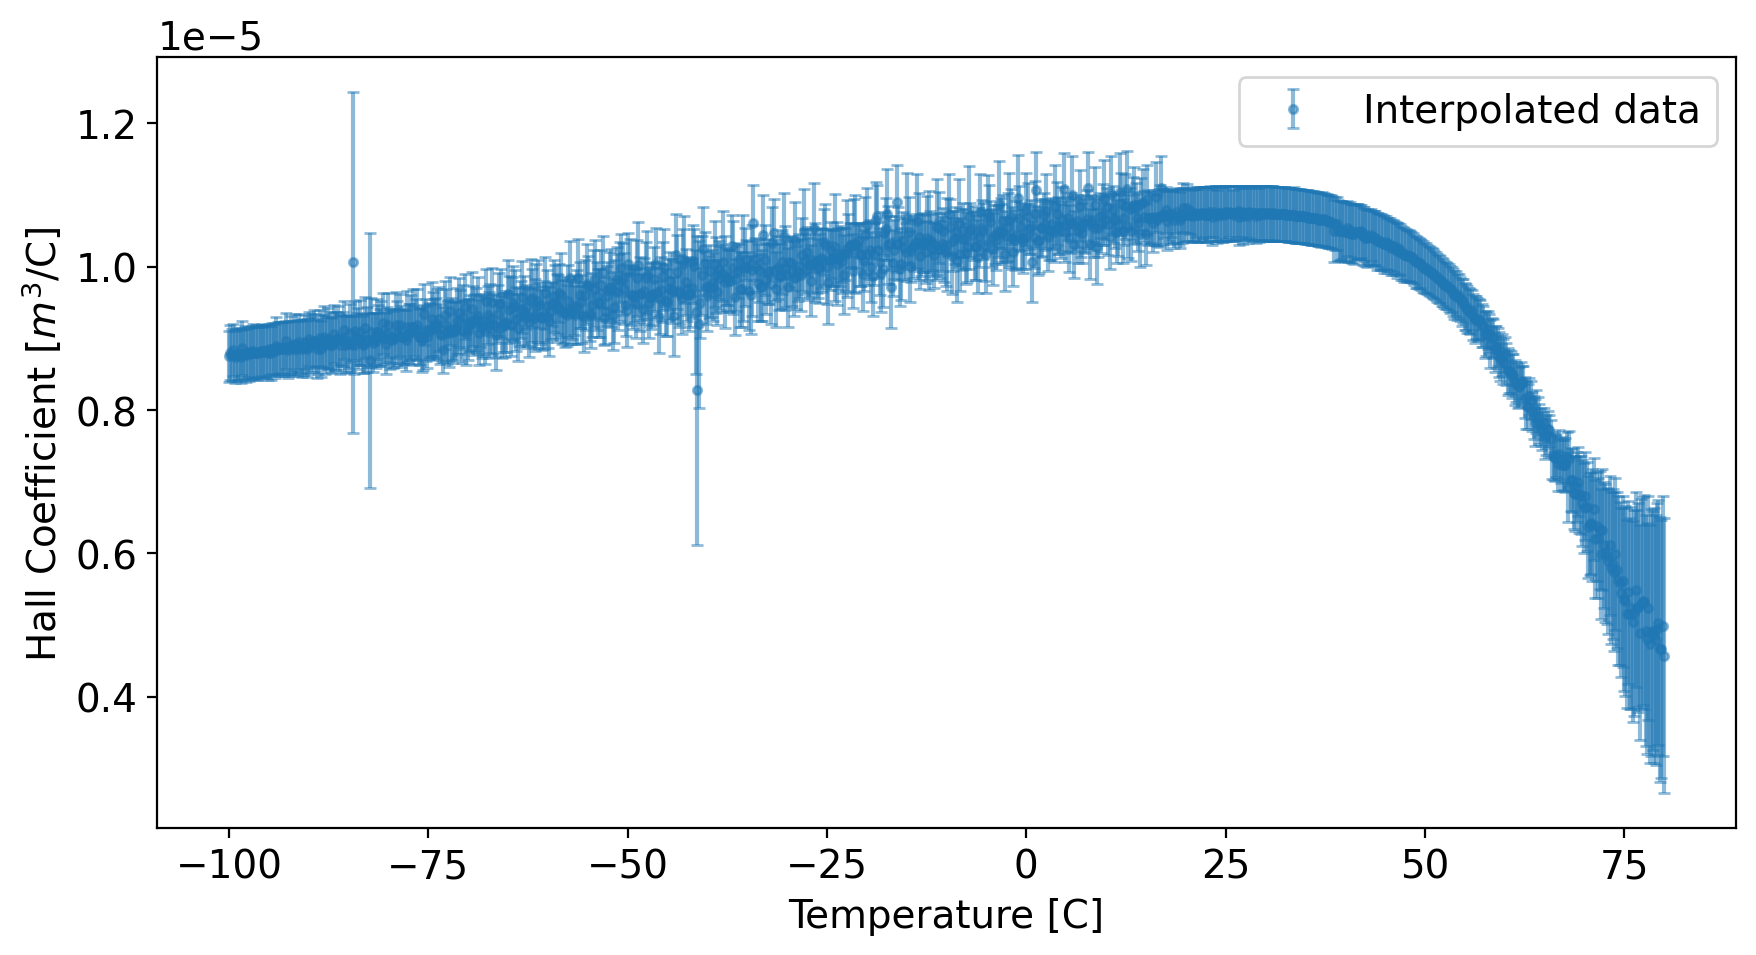

At 80.0 C: RH = 4.58e-06 ± 1.92e-06 m^3/C
At 16.9 C: RH = 1.11e-05 ± 4.39e-07 m^3/C


In [194]:
n = np.array([n_dict[temp] for temp in T_common])
n_err = np.array([n_err_dict[temp] for temp in T_common])
RH, RH_err = hall_coeff_plot(n, n_err)


# Getting RH range
RH_min_index = np.argmin(RH)
RH_min = RH[RH_min_index]
RH_min_err = RH_err[RH_min_index]
RH_min_T = T_common[RH_min_index]

RH_max_index = np.argmax(RH)
RH_max = RH[RH_max_index]
RH_max_err = RH_err[RH_max_index]
RH_max_T = T_common[RH_max_index]

print(f"At {RH_min_T:.1f} C: RH = {RH_min:.2e} ± {RH_min_err:.2e} m^3/C")
print(f"At {RH_max_T:.1f} C: RH = {RH_max:.2e} ± {RH_max_err:.2e} m^3/C")